In [72]:
import matplotlib.pyplot as plt
import panel as pn

pn.extension(template="fast")
pn.config.comms = "ipywidgets"
import xarray as xr

import cfspopcon
from cfspopcon.unit_handling import ureg
from cfspopcon.named_options import ConfinementScaling
import yaml
from typing import List
import git

PROJECT_NAME = "SPRING_2024_2263"
input_parameters, algorithm, points = cfspopcon.read_case(f"../../example_cases/{PROJECT_NAME}")
plot_style = cfspopcon.read_plot_style(f"../../example_cases/{PROJECT_NAME}/plot_popcon.yaml")
algorithm.validate_inputs(input_parameters)
dataset = xr.Dataset(input_parameters)
repo = git.Repo(search_parent_directories=True)
sha = repo.head.commit.hexsha
short_sha = repo.git.rev_parse(sha, short=True)

In [73]:
confinement_names = ConfinementScaling._member_map_.keys()
select_confinement = pn.widgets.Select(name="Select", options=list(confinement_names)).servable(target="sidebar")

In [74]:
with open("gui.yaml", "r") as file:
    gui_config = yaml.safe_load(file)


def build_sliders(gui_config: dict, target: str) -> List[pn.widgets.FloatSlider]:
    sliders = {}
    units = {}
    for slide_conf in gui_config["sliders"]:
        slider = pn.widgets.FloatSlider(
            name=slide_conf["name"],
            start=slide_conf["start"],
            end=slide_conf["end"],
            value=slide_conf["default"],
            step=slide_conf["step_size"],
        ).servable(target=target)
        sliders[slide_conf["name"]] = slider
        units[slide_conf["name"]] = slide_conf["unit"]
    return sliders, units


sliders, units = build_sliders(gui_config, "sidebar")

BokehModel(combine_events=True, render_bundle={'docs_json': {'40627e08-ae58-4c38-9731-af21629935da': {'version…

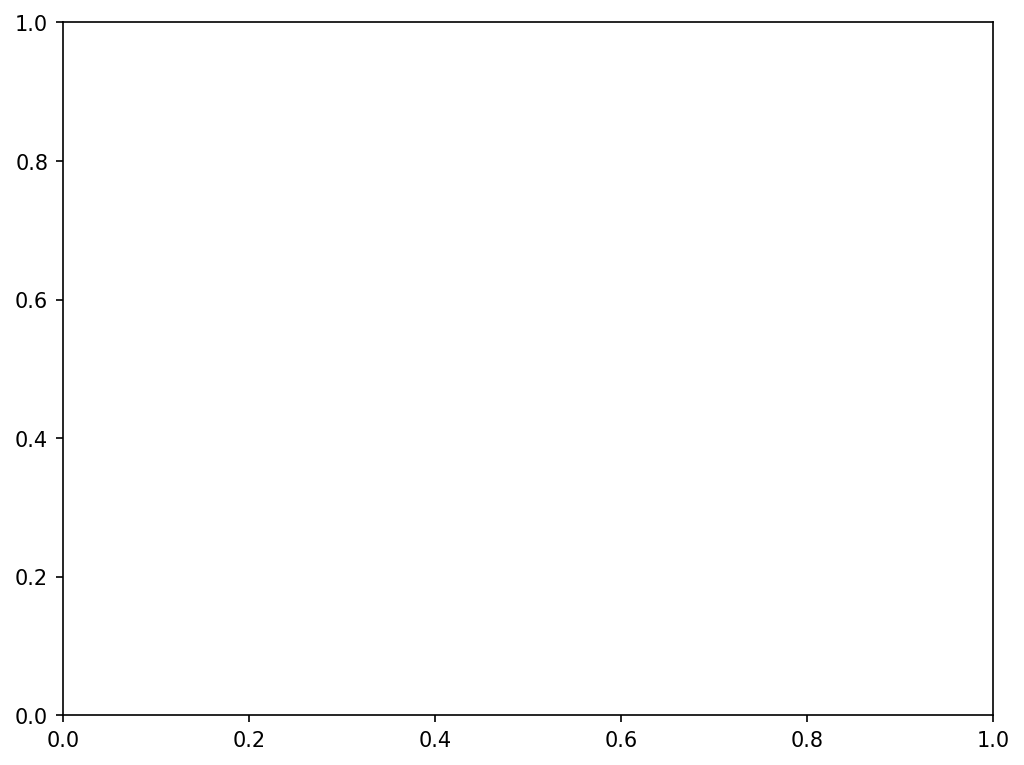

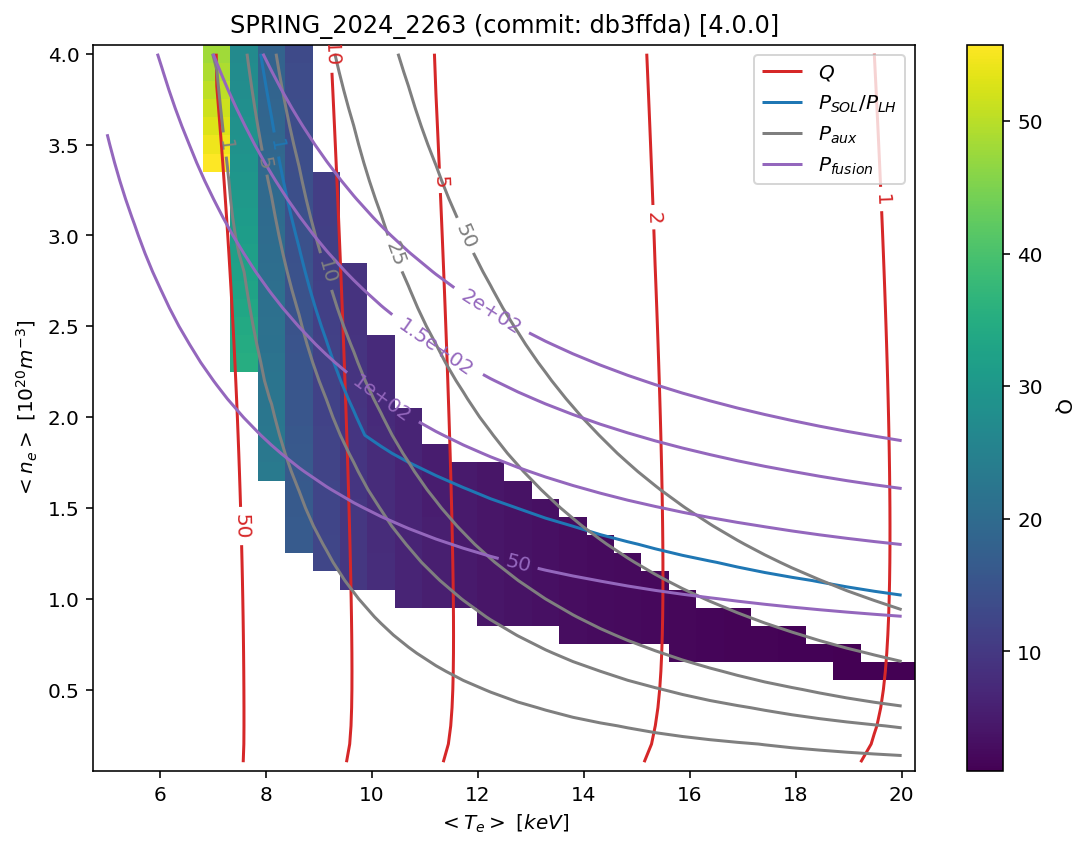

In [75]:
_, ax = plt.subplots(figsize=plot_style["figsize"], dpi=plot_style["show_dpi"])


def make_plot(select_confinement: str, **kwargs):
    dataset["energy_confinement_scaling"] = ConfinementScaling._member_map_[select_confinement]
    for key, value in kwargs.items():
        dataset[key] = value * ureg(units[key])
    algorithm.update_dataset(dataset, in_place=True)
    fig, ax = cfspopcon.plotting.make_plot(dataset, plot_style, points={}, title=f"{PROJECT_NAME} (commit: {short_sha})", output_dir=None)
    return pn.pane.Matplotlib(fig)


interactive_plot = pn.param.ParamFunction(pn.bind(make_plot, select_confinement=select_confinement, **sliders), loading_indicator=True)
app = pn.Column(interactive_plot)
app.servable(target="main")